# Preprocess Motor Imagery Data

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline

import mne
from mne import Epochs, pick_types
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf

# Load & Segment the Data

In [12]:
df = pd.read_csv('../../data/MI/sidharth_motor_imagery_mov1=leftfootup_mov2=rightfootup_10-27-24.csv')
df = pd.read_csv('../../data/MI/kyle_motor_imagery_mov1=leftwristflex_mov2=rightwristflex_10-19-24.csv')
df = pd.read_csv('../../data/MI/sophie_motor_imagery_mov1=leftelbowbend_mov2=rightelbowbend_10-27-24.csv')

In [13]:
stim_labels, stim_idxs = np.unique(df['stim'], return_index=True)

# Preprocess

In [14]:
data = df.iloc[:, 1:-1].values

sfreq = 250
ch_names = list(df.keys())[1:-1]
ch_types = ['eeg'] * len(ch_names)

# Create MNE Info object
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# Create RawArray
raw = mne.io.RawArray(data.T, info)
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)
raw.set_eeg_reference(projection=True)

Creating RawArray with float64 data, n_channels=8, n_times=293114
    Range : 0 ... 293113 =      0.000 ...  1172.452 secs
Ready.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


<RawArray | 8 x 293114 (1172.5 s), ~17.9 MB, data loaded>

In [15]:
ch_names

['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']

In [16]:
# Band-pass filter between 1 and 40 Hz
# raw.filter(l_freq=1.0, h_freq=40.0)
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s finished


<RawArray | 8 x 293114 (1172.5 s), ~17.9 MB, data loaded>

# Epoch Data

In [19]:
event_id = {'left_movement': 0, 'right_movement': 1}
trial_start_idxs = []
labels = []

for i, stim in enumerate(stim_labels[11:-1]):
    str_stim = str(int(stim))

    if str_stim[-2] == '5': 
        trial_start_idxs.append(stim_idxs[11:-1][i])
        labels.append(0 if str_stim[-1] == '1' else 1)
        

events = np.zeros((len(trial_start_idxs), 3), dtype=int)
events[:, 0] = trial_start_idxs  # First column: sample indices
events[:, 2] = labels

# Calculate duration in seconds
trial_duration = 2500
trial_duration_sec = trial_duration / sfreq

In [38]:
epochs = mne.Epochs(raw,
                    events,
                    event_id=event_id,
                    tmin= 0,  # Start at trial onset
                    tmax=trial_duration_sec,  # End at trial duration
                    baseline=None,  # No baseline correction by default
                    preload=True)

Not setting metadata
59 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 59 events and 2501 original time points ...
0 bad epochs dropped


# Visualize EEG

In [39]:
epochs_data = epochs.get_data(copy=False)

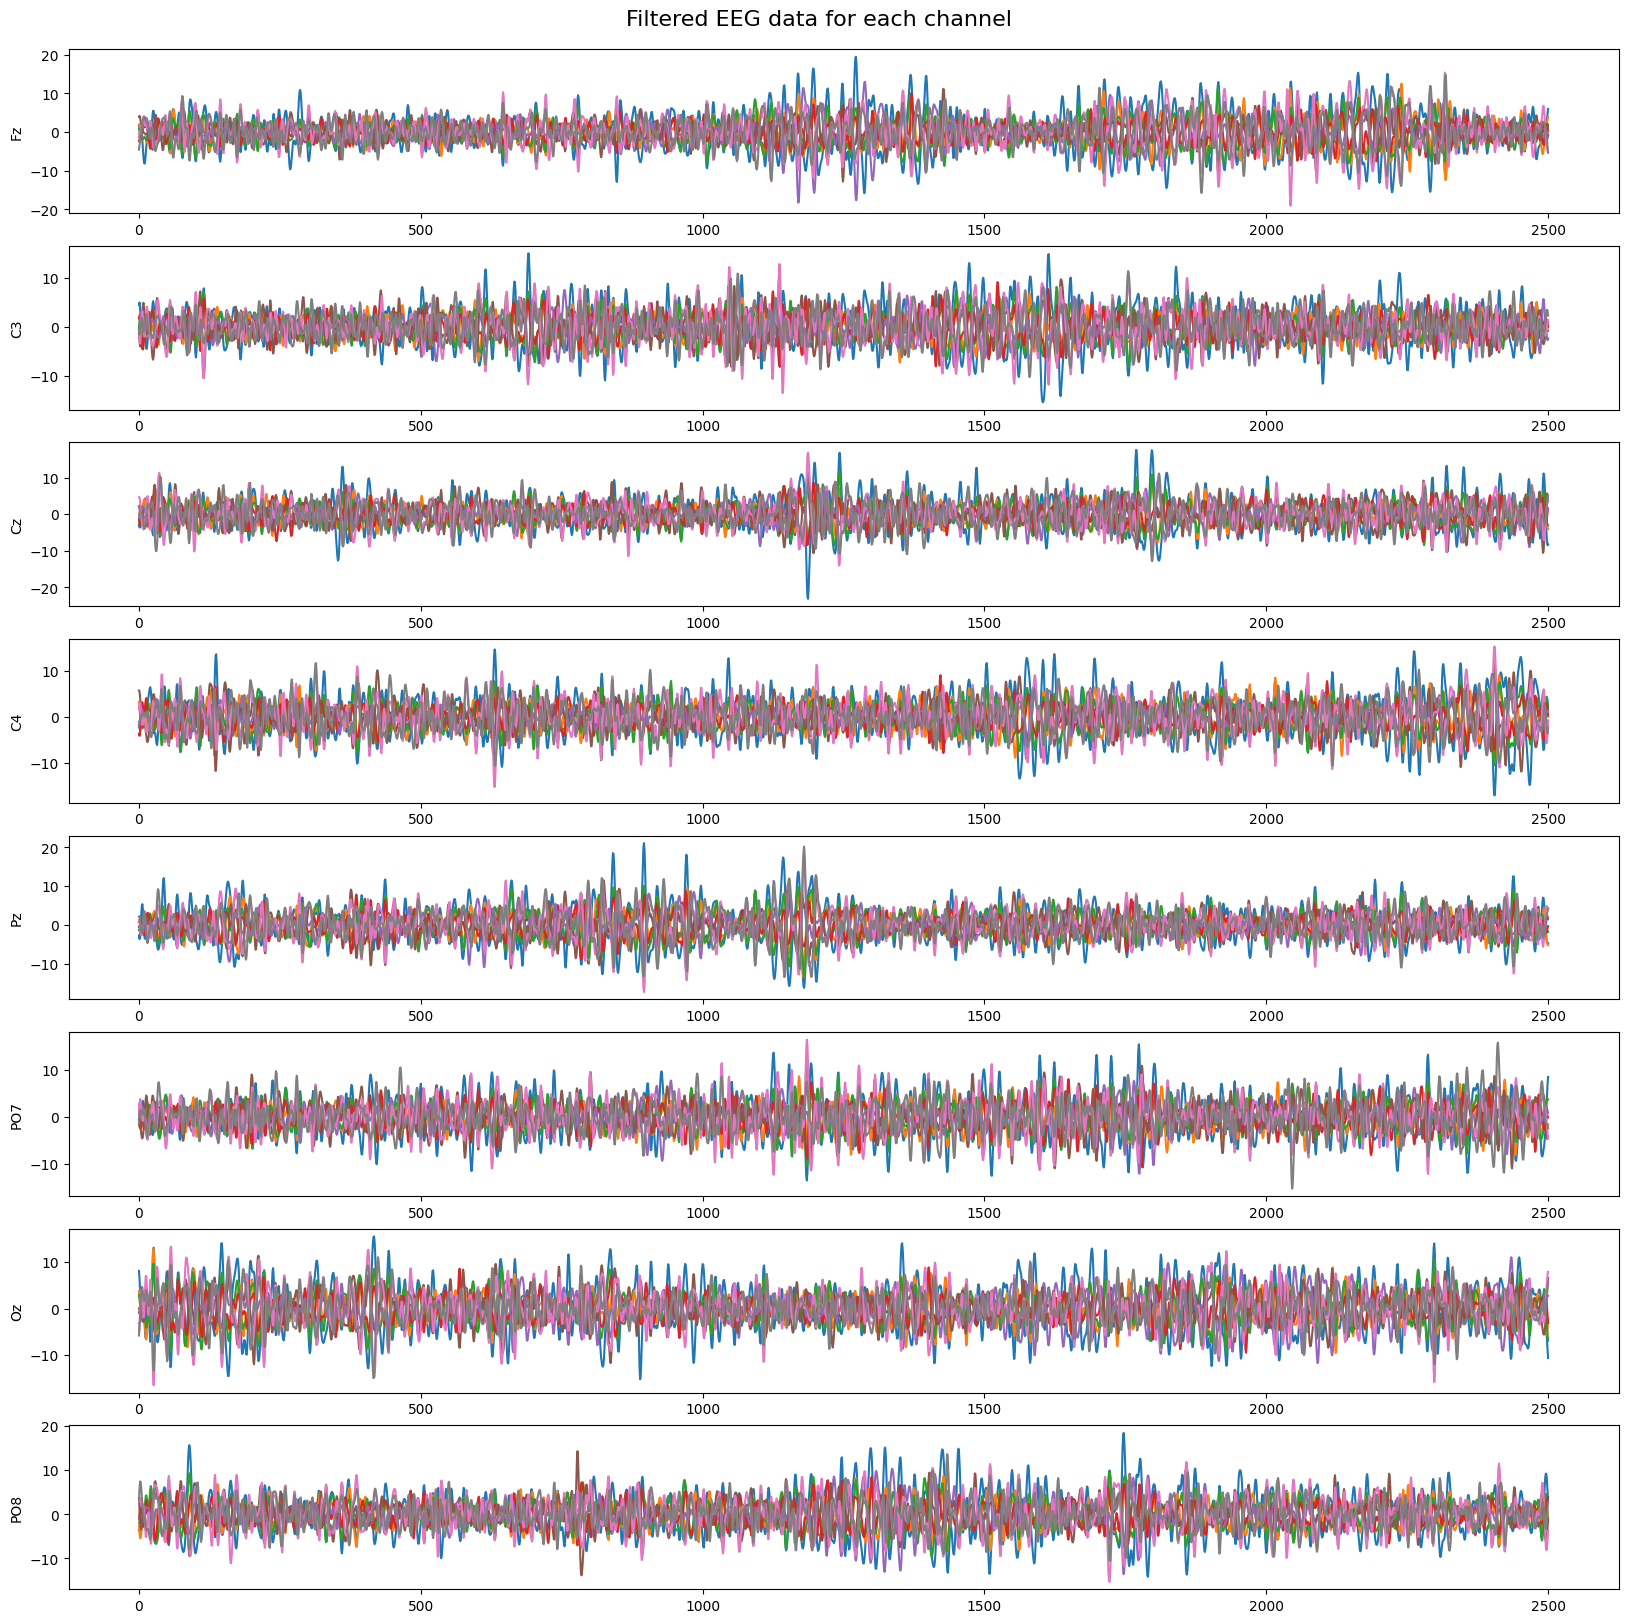

In [40]:
fig, axs = plt.subplots(8, figsize=(20, 20))

# Set the overall title for the figure with a specific y-position
fig.suptitle("Filtered EEG data for each channel", fontsize=16, y=0.9)

for i in range(epochs_data.shape[1]):
    axs[i].plot(epochs_data[i].T)
    axs[i].set_ylabel(ch_names[i])

plt.show()

# Train Model

In [41]:
epochs_train = epochs.copy()
labels = epochs.events[:, -1] - 2

In [42]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data_train = epochs_train.get_data(copy=False)
cv = ShuffleSplit(10, test_size=0.2, random_state=60)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=6, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(f"Classification accuracy: {np.mean(scores)} / Chance level: {class_balance}")

Computing rank from data with rank=None


    Using tolerance 4.5 (2.2e-16 eps * 8 dim * 2.6e+15  max singular value)
    Estimated rank (data): 7
    data: rank 7 computed from 8 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 8 -> 7
Estimating class=-2 covariance using EMPIRICAL
Done.
Estimating class=-1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.6 (2.2e-16 eps * 8 dim * 2.6e+15  max singular value)
    Estimated rank (data): 7
    data: rank 7 computed from 8 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 8 -> 7
Estimating class=-2 covariance using EMPIRICAL
Done.
Estimating class=-1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.6 (2.2e-16 eps * 8 dim * 2.6e+15  max singular value)
    Estimated rank (data): 7
    data: rank 7 computed from 8 data channels with 0 projectors
    Setting small data

# Visualize CSP

Computing rank from data with rank=None
    Using tolerance 5.1 (2.2e-16 eps * 8 dim * 2.9e+15  max singular value)
    Estimated rank (data): 7
    data: rank 7 computed from 8 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 8 -> 7
Estimating class=-2 covariance using EMPIRICAL
Done.
Estimating class=-1 covariance using EMPIRICAL
Done.


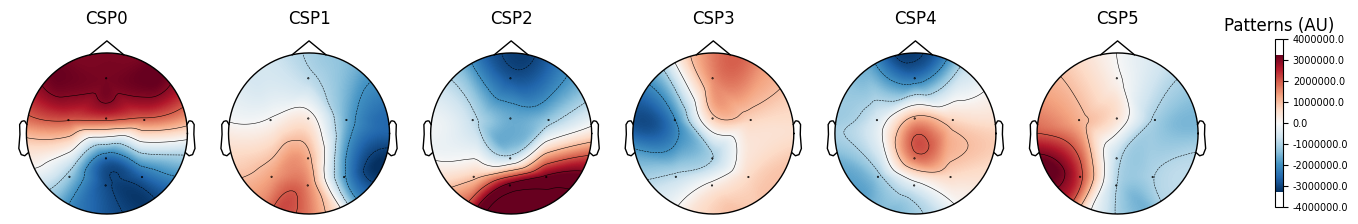

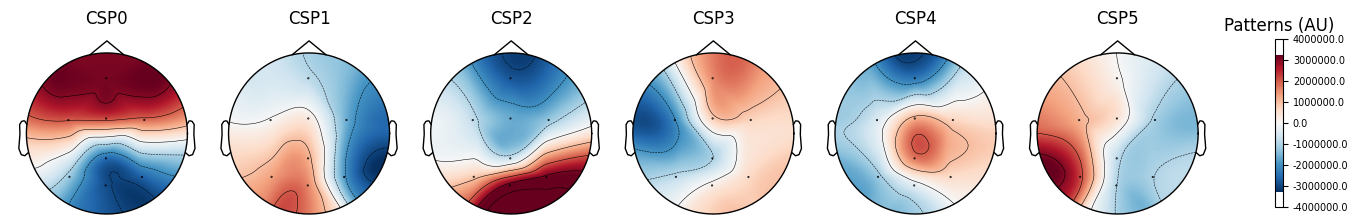

In [43]:
csp.fit_transform(epochs_data, labels)
csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

# Misc.

## Segment Data

In [8]:
filtered_data = raw.get_data().T

In [40]:
segmented_data = []

for i in range(len(stim_idxs) - 1):
    if i == len(stim_idxs) - 2:
        segmented_data.append(filtered_data[stim_idxs[i]:])
    else:
        segmented_data.append(filtered_data[stim_idxs[i]:stim_idxs[i + 1]])

segmented_data = segmented_data[11:] # First 11 trials are to prepare the subject we can remove that data

In [43]:
X = []
y = []

for i, stim in enumerate(stim_labels[11:-1]):
    str_stim = str(int(stim))

    if str_stim[-2] == '5': 
        y.append(0 if str_stim[-1] == '1' else 1)
        X.append(segmented_data[i][:2500])

X = np.array(X).transpose(0, 2, 1)
y = np.array(y)

## Train the ML Model

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline

In [60]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=50)

In [61]:
pipeline = make_pipeline(CSP(n_components=8), LDA()) # Creation of the pipeline only takes one line of code! (thanks to the hard work of developers creating these libraries)
pipeline.fit(train_X, train_y)

Computing rank from data with rank=None
    Using tolerance 43 (2.2e-16 eps * 8 dim * 2.4e+16  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


Pipeline(steps=[('csp',
                 CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 8,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})),
                ('lineardiscriminantanalysis', LinearDiscriminantAnalysis())])

In [62]:
pipeline.score(test_X, test_y) # Performs better! Can we improve this even more?

0.6666666666666666

In [63]:
pipeline.predict(test_X)

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1])

In [64]:
test_y

array([1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1])